## Nowcast Upwelling Analysis

In [1]:
from salishsea_tools import grid_tools, gsw_calls, nc_tools
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec
from cmocean import cm
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Functions

In [38]:
def make_map(ax, grid, bathy=False, w_map=[-124, -123.9, 47.7, 50.6], rotation=39.2):
    """
    """

    # Make projection
    m = Basemap(ax=ax, projection='lcc', resolution='c',
                lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0] + rotation,
                lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])

    # Add features and labels
    x, y = m(grid.longitude.values, grid.latitude.values)
    if bathy:
        C = ax.contourf(x, y, grid.bathymetry, cmap='Blues', extend='both', levels=range(0, 451, 50))
    ax.contourf(x, y, grid.bathymetry, [-0.01, 0.01], colors='burlywood')
    ax.contour(x, y, grid.bathymetry, [-0.01, 0.01], colors='black')
    m.drawmeridians(np.arange(-125.5, -122, 0.5), labels=[0, 0, 0, 1])
    m.drawparallels(np.arange(48, 51, 0.5), labels=[1, 0, 0, 0])
    
    return m, x, y, C

### Load and prepare data
Load ERDDAP datasets

In [3]:
# Load ERDDAP datasets
grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02', mask_and_scale=False)
grid_GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02')
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
SSH = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSgSurfaceTracerFields1hV17-02')
V = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DvGridFields1hV17-02')
T = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

Slice parameters

In [4]:
# Slice Parameters
section = {}
section['N'] = [640, slice(120, 180)]
section['S'] = [590, slice(130, 205)]
section['GEM'] = [170, slice(107, 120)]
windrange = ['2017 May 20 00:00', '2017 June 20 00:00']
NEMOrange = ['2017 May 25 00:00', '2017 June 15 00:00']
dates = ['2017 May 26 00:00', '2017 June 4 00:00', '2017 June 13 00:00']

Slice GEM record

In [5]:
# Slice GEM record
GEM_slice = GEM.v_wind.sel(time=slice(*windrange)).isel(gridY=section['GEM'][0], gridX=section['GEM'][1])
grid_GEM_slice = grid_GEM.isel(gridY=section['GEM'][0], gridX=section['GEM'][1])

In [6]:
# Extract v wind
v_wind = GEM_slice.values

Build GEM Mask

In [4]:
# Build GEM mask
mask_GEM = grid_tools.build_GEM_mask(grid_GEM, grid, mask.tmask.isel(time=0, gridZ=0))

Building GEM mask 100% (68096 of 68096) |###################################|Time: 0:18:54


Slice NEMO sections

In [8]:
# Slice NEMO sections
NEMO = {'N': {'grid': {}, 'vvl': {}}, 'S': {'grid': {}, 'vvl': {}}}
NEMO['time'] = SSH.time.sel(time=slice(*NEMOrange)).indexes['time']
for sxn in ['N', 'S']:
    for xr_obj, key in zip([SSH, T, T, V], ['ssh', 'temperature', 'salinity', 'vVelocity']):
        NEMO[sxn][key] = xr_obj[key].sel(time=slice(*NEMOrange), gridY=section[sxn][0], gridX=section[sxn][1]).values
    for xr_obj, key in zip([mask, mask, mask, grid, grid, grid], ['e3t_0', 'gdept_0', 'tmask', 'longitude', 'latitude', 'bathymetry']):
        NEMO[sxn]['grid'][key] = xr_obj[key].sel(gridY=section[sxn][0], gridX=section[sxn][1]).values

Calculate VVL depths

In [9]:
# Calculate VVL depths
for sxn in ['N', 'S']:
    input_vars = {'e3t_0': NEMO[sxn]['grid']['e3t_0'], 'gdept_0': NEMO[sxn]['grid']['gdept_0']}
    NEMO[sxn]['vvl'] = grid_tools.calculate_time_dependent_grid(
        NEMO[sxn]['grid']['e3t_0'][0, ...],
        NEMO[sxn]['grid']['tmask'][0, ...],
        NEMO[sxn]['ssh'], input_vars,
    )

Calculate density

In [10]:
# Calculate density
for sxn in ['N', 'S']:
    lat = NEMO[sxn]['grid']['latitude'][np.newaxis, np.newaxis, :] * np.ones(NEMO[sxn]['vvl']['gdept_t'].shape)
    NEMO[sxn]['pressure'] = gsw_calls.generic_gsw_caller('gsw_p_from_z', [-NEMO[sxn]['vvl']['gdept_t'], lat])
    NEMO[sxn]['rho'] = gsw_calls.generic_gsw_caller(
        'gsw_rho', [NEMO[sxn]['salinity'], NEMO[sxn]['temperature'], NEMO[sxn]['pressure']],
    )

### Results

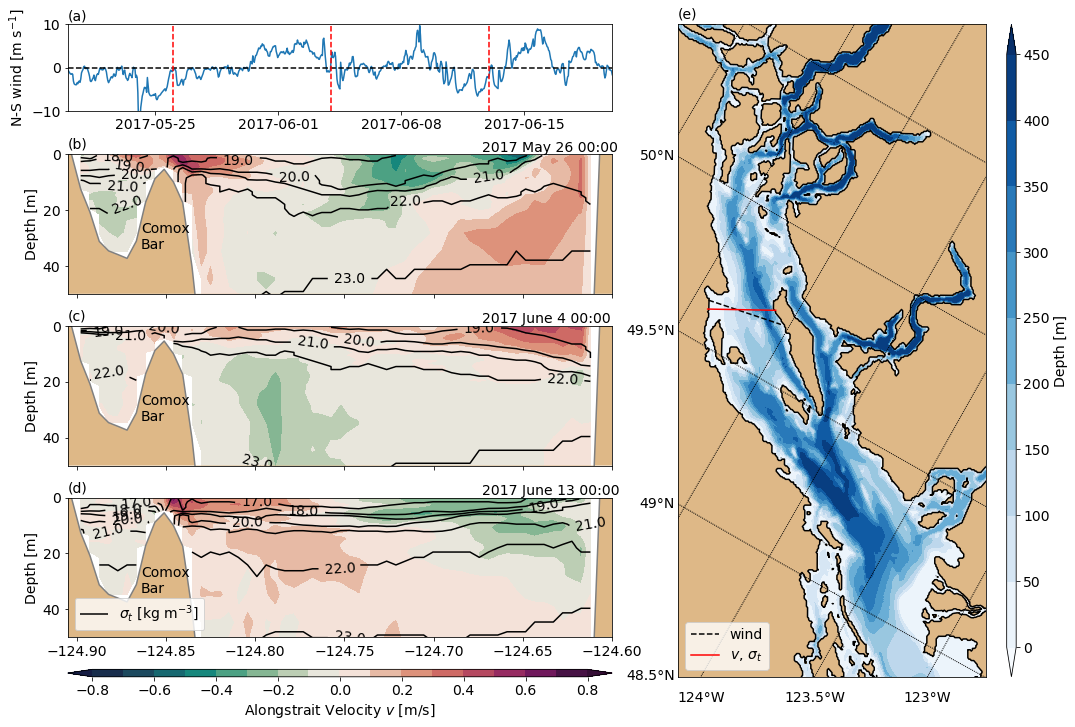

In [95]:
# Make figure and axes handles
gs, axs = {}, {}
fig = plt.figure(figsize=(17, 12))
gs['left'] = gridspec.GridSpec(4, 1, height_ratios=[1.5, 1.5, 1.5, 0.08], hspace=0.3)
gs['right'] = gridspec.GridSpec(1, 2, width_ratios=[1, 0.03], wspace=0.1)
gs['wind'] = gridspec.GridSpec(1, 1)
gs['left'].update(right=0.57, top=0.73)
gs['wind'].update(right=0.57, bottom=0.78)
gs['right'].update(left=0.62)
axs['map'] = fig.add_subplot(gs['right'][0])
axs['map_bar'] = fig.add_subplot(gs['right'][1])
axs['wind'] = fig.add_subplot(gs['wind'][0])
axs['section_bar'] = fig.add_subplot(gs['left'][3])
axs['section'] = [fig.add_subplot(gs['left'][row]) for row in range(3)]

# Plot Map
m, x, y, C_map = make_map(axs['map'], grid, bathy=True, w_map=[-124.1, -124.4, 48.5, 50.9])
x_GEM, y_GEM = m(grid_GEM_slice.longitude.values, grid_GEM_slice.latitude.values)
axs['map'].plot(x_GEM, y_GEM, 'k--', label='wind')
axs['map'].plot(x[section['N']], y[section['N']], 'r-', label='$v$, $\sigma_t$')
axs['map'].text(0, 1.01, '(e)', transform=axs['map'].transAxes)
axs['map'].legend(loc='lower left')

# Plot Wind
axs['wind'].plot(GEM_slice.time, v_wind.mean(axis=1))
axs['wind'].plot(windrange, [0, 0], 'k--')
for date in dates:
    axs['wind'].plot([date, date], [-10, 10], 'r--')
axs['wind'].set_xlim(windrange)
axs['wind'].set_ylim([-10, 10])
axs['wind'].set_ylabel('N-S wind [m s$^{-1}$]')
axs['wind'].text(0, 1.05, '(a)', transform=axs['wind'].transAxes)

# Plot Sections
for ax, subplot, date in zip(axs['section'], ['(b)', '(c)', '(d)'], dates):
    index = abs(NEMO['time'] - pd.Timestamp(date)).argmin()
    C_section = ax.contourf(
        NEMO['N']['grid']['longitude'], T.depth.values,
        np.ma.masked_where(NEMO['N']['grid']['tmask'][0, ...]==0, NEMO['N']['vVelocity'][index, ...]),
        levels=np.arange(-0.8, 0.9, 0.1), cmap=cm.curl, extend='both',
    )
    CS_section = ax.contour(
        NEMO['N']['grid']['longitude'], T.depth.values,
        np.ma.masked_where(NEMO['N']['grid']['tmask'][0, ...]==0, NEMO['N']['rho'][index, ...] - 1000),
        levels=[17, 18, 19, 20, 21, 22, 23], colors='k',
    )
    ax.fill_between(NEMO['N']['grid']['longitude'], NEMO['N']['grid']['bathymetry'], 50, facecolor='burlywood')
    ax.plot(NEMO['N']['grid']['longitude'], NEMO['N']['grid']['bathymetry'], color='gray')
    ax.set_xlim([-124.905, -124.6])
    ax.set_ylim([50, 0])
    ax.set_ylabel('Depth [m]')
    ax.text(0.76, 1.02, date, transform=ax.transAxes)
    ax.text(0, 1.04, subplot, transform=ax.transAxes)
    ax.text(0.135, 0.32, 'Comox\nBar', transform=ax.transAxes)
    plt.clabel(CS_section, fmt='%0.1f')
axs['section'][0].xaxis.set_ticklabels([])
axs['section'][1].xaxis.set_ticklabels([])
plt.legend([CS_section.collections[0]], ['$\sigma_t$ [kg m$^{-3}$]'], loc='lower left')

# Colorbars
fig.colorbar(C_section, cax=axs['section_bar'], orientation='horizontal', extend='both', label='Alongstrait Velocity $v$ [m/s]')
fig.colorbar(C_map, cax=axs['map_bar'], orientation='vertical', extend='both', label='Depth [m]')
fig.savefig('/home/bmoorema/Desktop/density.png', dpi=300, bbox_inches='tight')